In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from gurobipy import Model, GRB, quicksum
import seaborn as sns

# Load and preprocess the dataset
data = load_breast_cancer()
X, y = data.data, data.target
y = 2 * y - 1  # Convert labels to {-1, 1}

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Problem parameters
n, p = X_train.shape
M = 1e6  # Large constant for big-M constraints

In [26]:
def train_robust_svm(X_train, y_train, X_test, y_test, Gamma, M):
    """
    Train a robust SVM using Gurobi and evaluate accuracy.
    
    Parameters:
        X_train: Training features
        y_train: Training labels
        X_test: Test features
        y_test: Test labels
        Gamma: Robustness parameter
        M: Big-M constant
    
    Returns:
        Accuracy on the test set.
    """
    model = Model(f"Robust_SVM_Gamma_{Gamma}")

    n, p = X_train.shape  # n: number of samples, p: number of features

    # Decision variables
    w = model.addVars(p, lb=-GRB.INFINITY, name="w")  # Weight vector
    b = model.addVar(lb=-GRB.INFINITY, name="b")      # Bias term
    xi = model.addVars(n, lb=0, name="xi")            # Slack variables
    phi = model.addVars(n, lb=0, name="phi")          # Auxiliary variables
    r = model.addVars(n, lb=0, name="r")              # Robustness variables
    q = model.addVar(lb=0, name="q")                  # Aggregate robustness adjustment
    s = model.addVars(n, vtype=GRB.BINARY, name="s")  # Binary variables for slack
    t = model.addVars(n, vtype=GRB.BINARY, name="t")  # Binary variables for auxiliary

    # Objective function
    model.setObjective(quicksum(xi[i] + r[i] for i in range(n)) + Gamma * q, GRB.MINIMIZE)

    # Constraints from Theorem 4
    for i in range(n):
        # 1. Robustness constraint
        model.addConstr(q + r[i] >= phi[i] - xi[i])

        # 2. Lower bound for xi
        model.addConstr(xi[i] >= 1 - y_train[i] * (quicksum(w[j] * X_train[i, j] for j in range(p)) - b))

        # 3. Upper bound for xi with slack variable s
        model.addConstr(xi[i] <= 1 - y_train[i] * (quicksum(w[j] * X_train[i, j] for j in range(p)) - b) + M * (1 - s[i]))

        # 4. Slack variable s for xi
        model.addConstr(xi[i] <= M * s[i])

        # 5. Lower bound for phi
        model.addConstr(phi[i] >= 1 + y_train[i] * (quicksum(w[j] * X_train[i, j] for j in range(p)) - b))

        # 6. Upper bound for phi with auxiliary variable t
        model.addConstr(phi[i] <= 1 + y_train[i] * (quicksum(w[j] * X_train[i, j] for j in range(p)) - b) + M * (1 - t[i]))

        # 7. Auxiliary variable t for phi
        model.addConstr(phi[i] <= M * t[i])

    # 8. Binary variables
    model.addConstrs((s[i] <= 1 for i in range(n)), name="Binary_s")
    model.addConstrs((t[i] <= 1 for i in range(n)), name="Binary_t")

    # 9. Non-negativity of q
    model.addConstr(q >= 0)

    # Solve the model
    model.optimize()

    # Evaluate the model
    if model.status == GRB.OPTIMAL:
        w_opt = np.array([w[j].X for j in range(p)])
        b_opt = b.X
        y_pred = np.sign(X_test @ w_opt - b_opt)
        accuracy = np.mean(y_pred == y_test)
        return accuracy
    else:
        print(f"Gamma = {Gamma}: Optimization failed.")
        return None

Gamma vs Test Accuracy:
Training with Gamma = 0...
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4096 rows, 2307 columns and 63701 nonzeros
Model fingerprint: 0x1967f847
Variable types: 1397 continuous, 910 integer (910 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Found heuristic solution: objective 187710.38886
Presolve removed 1366 rows and 456 columns
Presolve time: 0.03s
Presolved: 2730 rows, 1851 columns, 60970 nonzeros
Variable types: 941 continuous, 910 integer (910 binary)

Root relaxation: objective 0.000000e+00, 1055 iterations, 0.06 seconds (0.21 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

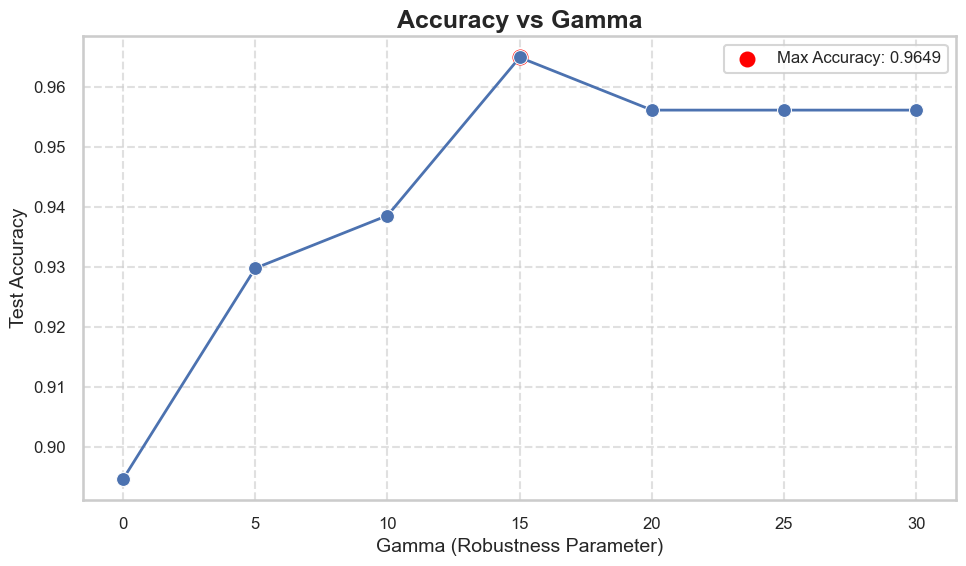

In [27]:
# Test different Gamma values
gamma_values = [0, 5, 10, 15, 20, 25, 30]
accuracies = []

print("Gamma vs Test Accuracy:")
print("========================")

for Gamma in gamma_values:
    print(f"Training with Gamma = {Gamma}...")
    accuracy = train_robust_svm(X_train, y_train, X_test, y_test, Gamma, M)
    if accuracy is not None:
        print(f"Gamma = {Gamma}, Test Accuracy: {accuracy:.4f}")
    accuracies.append(accuracy)

# Print all results
print("\nFinal Results:")
for gamma, acc in zip(gamma_values, accuracies):
    print(f"Gamma = {gamma}, Test Accuracy = {acc:.4f}")

# Configure Seaborn style
sns.set(style="whitegrid", context="talk")

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(x=gamma_values, y=accuracies, marker='o', color='b', linewidth=2, markersize=10)

# Add titles and labels
plt.title("Accuracy vs Gamma", fontsize=18, fontweight="bold")
plt.xlabel("Gamma (Robustness Parameter)", fontsize=14)
plt.ylabel("Test Accuracy", fontsize=14)

# Highlight the maximum accuracy point
max_acc = max(accuracies)
max_gamma = gamma_values[accuracies.index(max_acc)]
plt.scatter(max_gamma, max_acc, color='red', s=100, label=f"Max Accuracy: {max_acc:.4f}")
plt.legend(fontsize=12)

# Adjust ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show gridlines and plot
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()